In [1]:
import sys
sys.path.append('../')

In [2]:
######################## Load modules ###################################
%matplotlib inline
import sys
import importlib
import time
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from cartopy.util import add_cyclic_point
import cartopy.crs as ccrs
from scipy import stats

from plants_and_TCR.analysis_parameters import directory_information
from plants_and_TCR.analysis_parameters import params
from plants_and_TCR.analysis_parameters import get_CMIP_info
from plants_and_TCR.analyze_data import grab_cmip_dataset
from plants_and_TCR.analyze_data import moving_average as movingaverage

####################### Set up directory structure ######################
PATH_REGRIDDED_DATA = directory_information.DIR_PROCESSED_DATA
PATH_FIGURES = directory_information.DIR_OUTPUT_FIGURES

In [3]:
from plants_and_TCR.analysis_parameters import params
DEFAULT_VARNAME = params.DEFAULT_VARNAME
runnames_all = params.RUNNAMES_ALL

dir_CMIPdicts = directory_information.DIR_DATA_DICTIONARIES
CMIP_DICT = pickle.load(open(dir_CMIPdicts+'cmip_dict.pickle',"rb"))

### Make Histograms

In [4]:
def get_baseline_values(modelname, varname=DEFAULT_VARNAME, runname='piControl',cmip_dict=CMIP_DICT, area_avg=None):
    pi_control_ds = grab_cmip_dataset.grab_cmip_dataset(cmip_dict,
                                                        modelname,
                                                        runname,
                                                        varname)
    if pi_control_ds is not None:
        pi_control = pi_control_ds[DEFAULT_VARNAME]
        cell_area = CMIP_DICT[modelname+'_'+'areacella']['areacella']
        area_weights = cell_area/cell_area.sum(dim=['lat','lon']).values
        
        land_frac = CMIP_DICT[modelname +'_sftlf']['sftlf'].reindex_like(cell_area, method='nearest', tolerance=0.001) # in values of 0 to 100
        glac_frac = CMIP_DICT[modelname +'_sftgif']['sftgif'].reindex_like(cell_area, method='nearest', tolerance=0.001)
        
        land_area = cell_area*(land_frac/100)*(1-(glac_frac/100))
        land_area_weights = land_area/land_area.sum(dim=['lat','lon']).values
        
        if area_avg =='land':
            pi_control_weighted = pi_control*land_area_weights
        elif ((area_avg == None) or (area_avg == 'global')):
            pi_control_weighted = pi_control*area_weights
        pi_control_global = pi_control_weighted.sum(dim=['lat','lon'])
        baseline = pi_control_global.mean(dim='time').values
        baseline_avgs = movingaverage.movingaverage(pi_control_global, 20*12) - baseline
    else:
        baseline_avgs=None
        baseline_avgs_years=None
        
    return baseline_avgs

In [5]:
modelnames = ['bcc-csm1-1','CanESM2','CESM1-BGC',
              'BCC-CSM2-MR','CanESM5','CESM2',
              'GFDL-ESM2M','HadGEM2-ES','IPSL-CM5A-LR',
              'GFDL-ESM4','UKESM1-0-LL','IPSL-CM6A-LR', 
              'NorESM1-ME','MPI-ESM-LR','',
              'NorESM2-LM','MPI-ESM1-2-LR','ACCESS-ESM1-5',
              '','','',
              'CNRM-ESM2-1','GISS-E2-1-G', 'MIROC-ES2L']

In [8]:
FIGURE_PATH = directory_information.DIR_OUTPUT_FIGURES
FONTSIZE=25
def plot_histograms(binnum, xlims,
                    varname=DEFAULT_VARNAME,
                    tcr=None,
                    avg_type=None):
    """Add docstring"""
    fig = plt.figure(figsize=(48, 24.5))
    mpl.rcParams.update({'font.size': FONTSIZE})
    mpl.rc('xtick', labelsize=FONTSIZE) 
    mpl.rc('ytick', labelsize=FONTSIZE) 
    ind=0
    for m in range(0, len(modelnames)):
        modelname = modelnames[m]  
        print(modelname)
        baseline_avgs = get_baseline_values(modelname, area_avg=avg_type)
        
        if baseline_avgs is not None:
            #----------Calculate Detrended Baseline
            times = np.arange(0,len(baseline_avgs))
            [slope, intercept, _, _, _] = stats.linregress(times, baseline_avgs)
            linearfit = slope*(times)+intercept
            detrended_baseline_avgs = baseline_avgs - linearfit
            print(np.std(detrended_baseline_avgs))

            #------------Make Subplot---------------------
            plt.subplot(4, 6, ind+1)
            plt.hist(baseline_avgs, bins=binnum, alpha=0.7, color='mediumblue')
            plt.hist(detrended_baseline_avgs, bins=10, alpha=0.5, color='lightgray')

            plt.axvline(0, color='k', linestyle='dashed', linewidth=1)
            if tcr is not None:
                plt.axvline(tcr[ind], color='k', linestyle='solid', linewidth=3)
            plt.title(modelname, fontsize=FONTSIZE+10)
            plt.xlim(xlims)
            if m in {12, 13, 8, 21, 22, 23}:
                plt.xlabel('20-year Mean  \n Temp. Anomaly', fontsize=FONTSIZE)
            if m in {0, 6, 12, 21}:
                plt.ylabel('Number of Years', fontsize=FONTSIZE)
        else:
            print('no data for '+modelname)
        ind = ind+1
    
    fig.subplots_adjust(hspace=.3)
    plt.show()
    fig.savefig(FIGURE_PATH +'piControl_variability_histograms'+'.png', bbox_inches='tight')
    return fig

bcc-csm1-1
0.0593849263502103
CanESM2
0.03499286204871295
CESM1-BGC
0.03291776086402121
BCC-CSM2-MR
0.14163287652818357
CanESM5
0.048013261334755974
CESM2
0.0615635394433053
GFDL-ESM2M
0.046704069879674265
HadGEM2-ES
0.0846028356852509
IPSL-CM5A-LR
0.04370687999199817
GFDL-ESM4
0.05998969111767299
UKESM1-0-LL
0.056486278090204976
IPSL-CM6A-LR
0.09186967046177584
NorESM1-ME
0.02443811156912614
MPI-ESM-LR
0.03957853537940946

_piControl_tas not in the dictionary
no data for 
NorESM2-LM
0.05873756673394799
MPI-ESM1-2-LR
0.023363846250879346
ACCESS-ESM1-5
0.054375792059853975

_piControl_tas not in the dictionary
no data for 

_piControl_tas not in the dictionary
no data for 

_piControl_tas not in the dictionary
no data for 
CNRM-ESM2-1
0.13033230954762434
GISS-E2-1-G
0.023311901924797408
MIROC-ES2L
0.03671309636836718


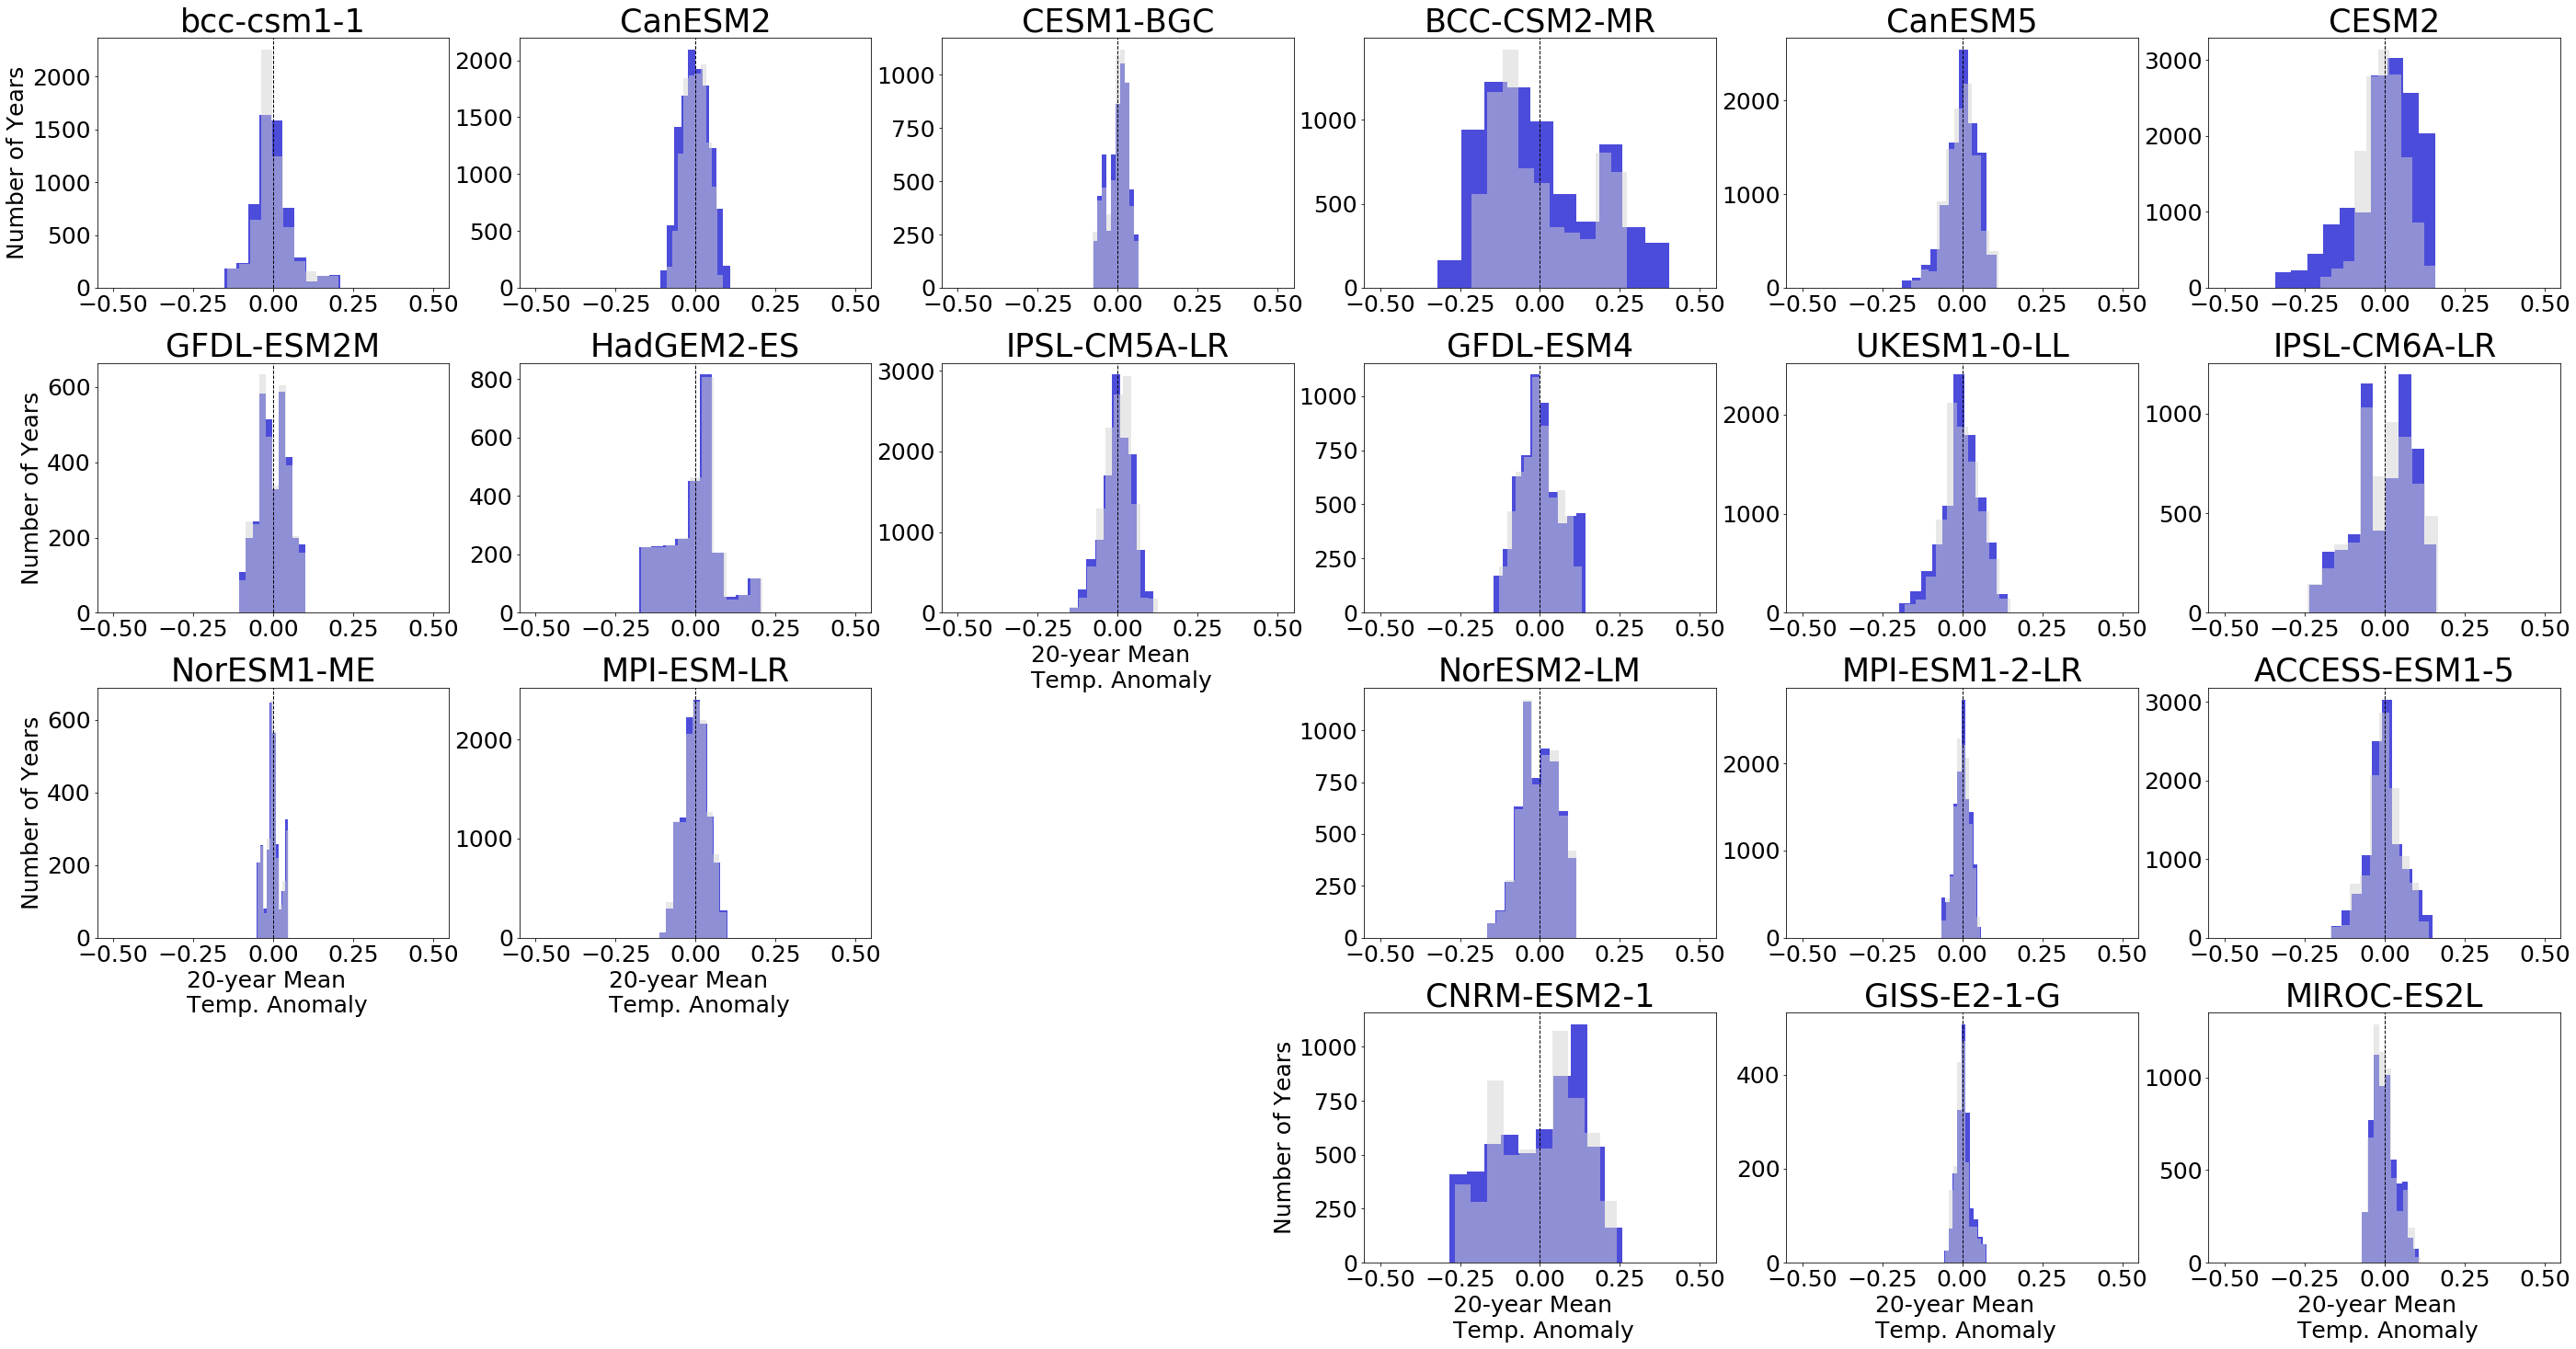

In [9]:
fig = plot_histograms(binnum=10, xlims=[-0.55,0.55],avg_type=None)

### Make single histogram for presentations

In [58]:
FIGURE_PATH = directory_information.DIR_OUTPUT_FIGURES
FONTSIZE=35
def plot_histogram_for_single_model(binnum, xlims, m, varname=DEFAULT_VARNAME,
                                    tcr=None, avg_type=None):
    """Add docstring"""
    fig = plt.figure(figsize=(24.5, 24.5))
    mpl.rcParams.update({'font.size': FONTSIZE})
    mpl.rc('xtick', labelsize=FONTSIZE) 
    mpl.rc('ytick', labelsize=FONTSIZE) 
    modelname = modelnames[m]  
    print(modelname)
    baseline_avgs = get_baseline_values(modelname, area_avg=avg_type)

    if baseline_avgs is not None:
        #----------Calculate Detrended Baseline
        times = np.arange(0,len(baseline_avgs))
        [slope, intercept, _, _, _] = stats.linregress(times, baseline_avgs)
        linearfit = slope*(times)+intercept
        detrended_baseline_avgs = baseline_avgs - linearfit
        print(np.std(detrended_baseline_avgs))

        #------------Make Subplot---------------------
        plt.subplot(1, 1, 1)
        plt.hist(baseline_avgs, bins=binnum, alpha=0.7, color='mediumblue')
        #plt.hist(detrended_baseline_avgs, bins=10, alpha=0.5, color='lightgray')

        plt.axvline(0, color='k', linestyle='dashed', linewidth=1)
        if tcr is not None:
            plt.axvline(tcr[ind], color='k', linestyle='solid', linewidth=3)
        plt.title(modelname, fontsize=FONTSIZE+10)
        plt.xlim(xlims)
        if m in {19, 20, 21, 22, 23}:
            plt.xlabel('20-year Mean  \n Temp. Anomaly', fontsize=FONTSIZE)
        if m in {0, 6, 12, 18}:
            plt.ylabel('Number of Years', fontsize=FONTSIZE)
    else:
        print('no data for '+modelname)
    
    fig.subplots_adjust(hspace=.3)
    plt.show()
    fig.savefig(FIGURE_PATH +'piControl_variability_histograms'+'.png', bbox_inches='tight')
    return fig

CNRM-ESM2-1
0.13033230954762434


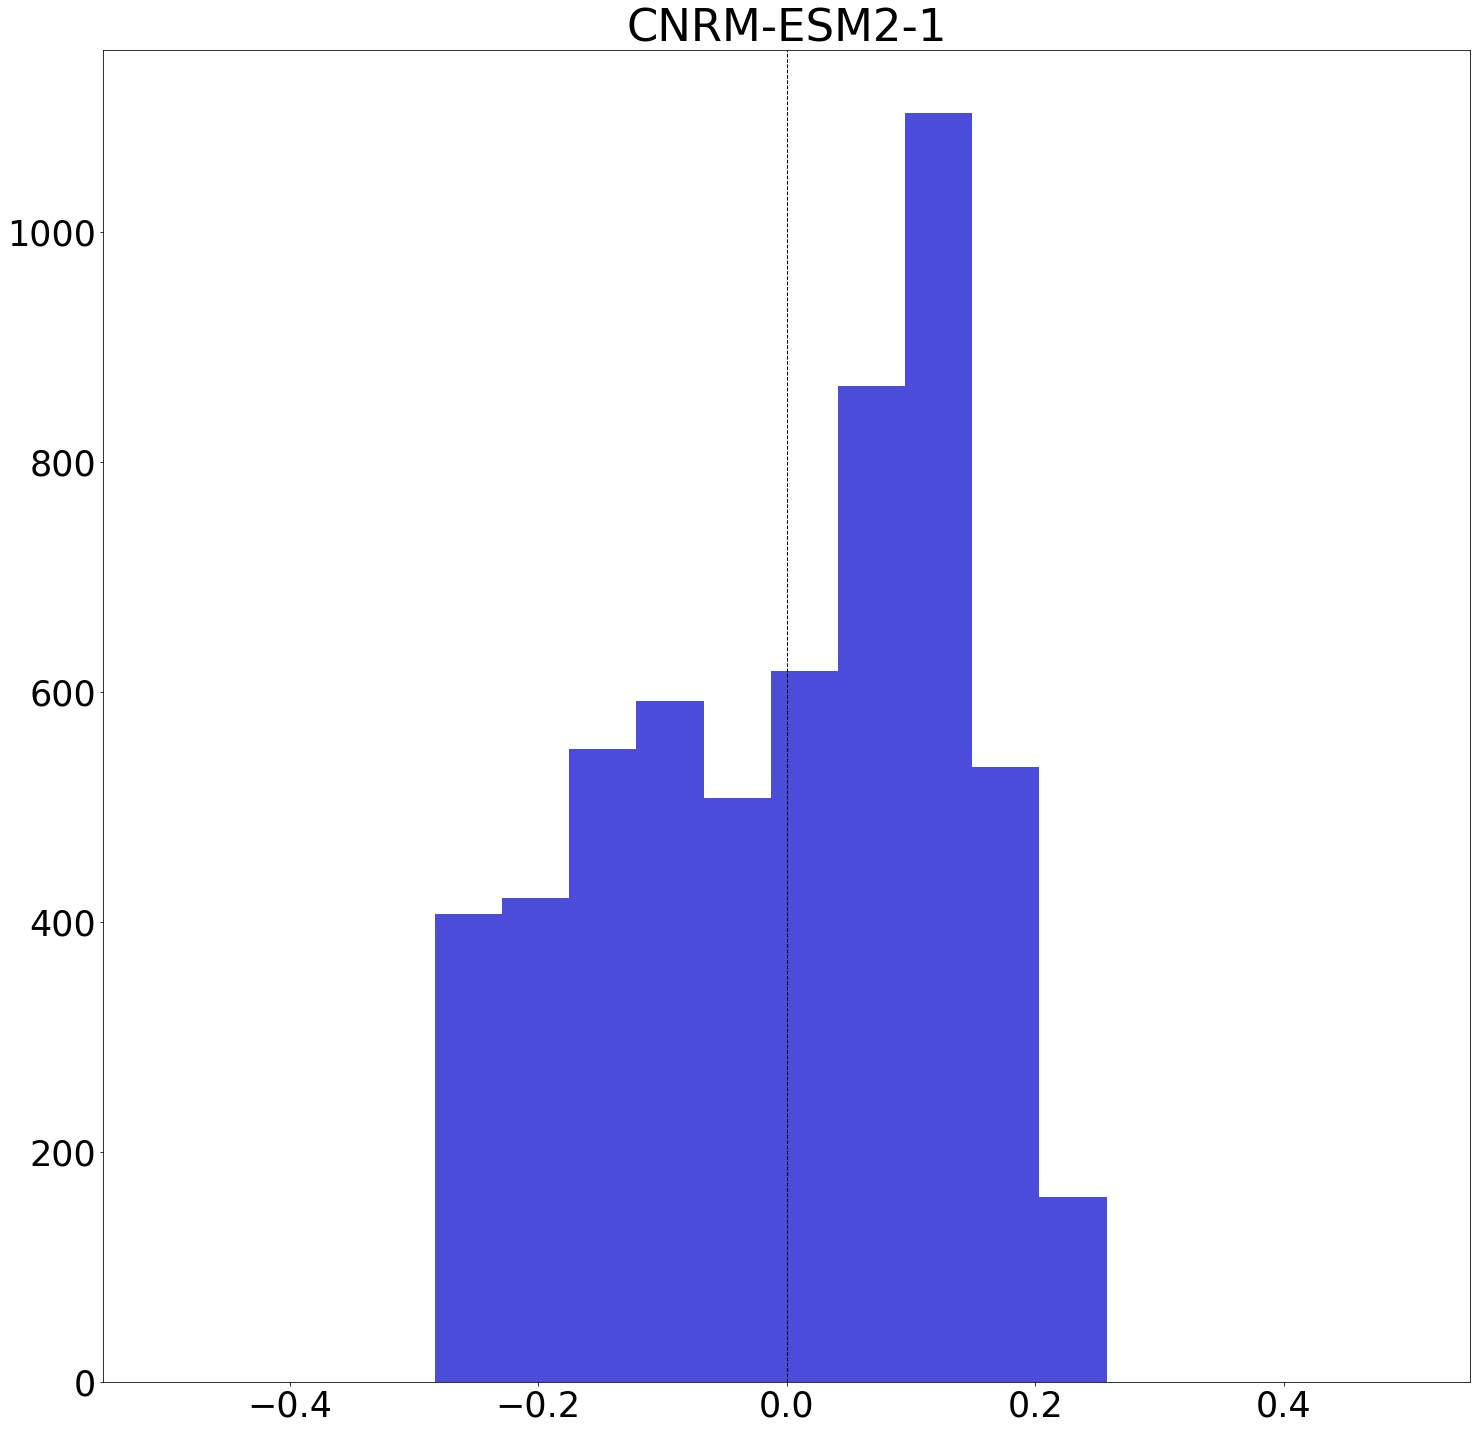

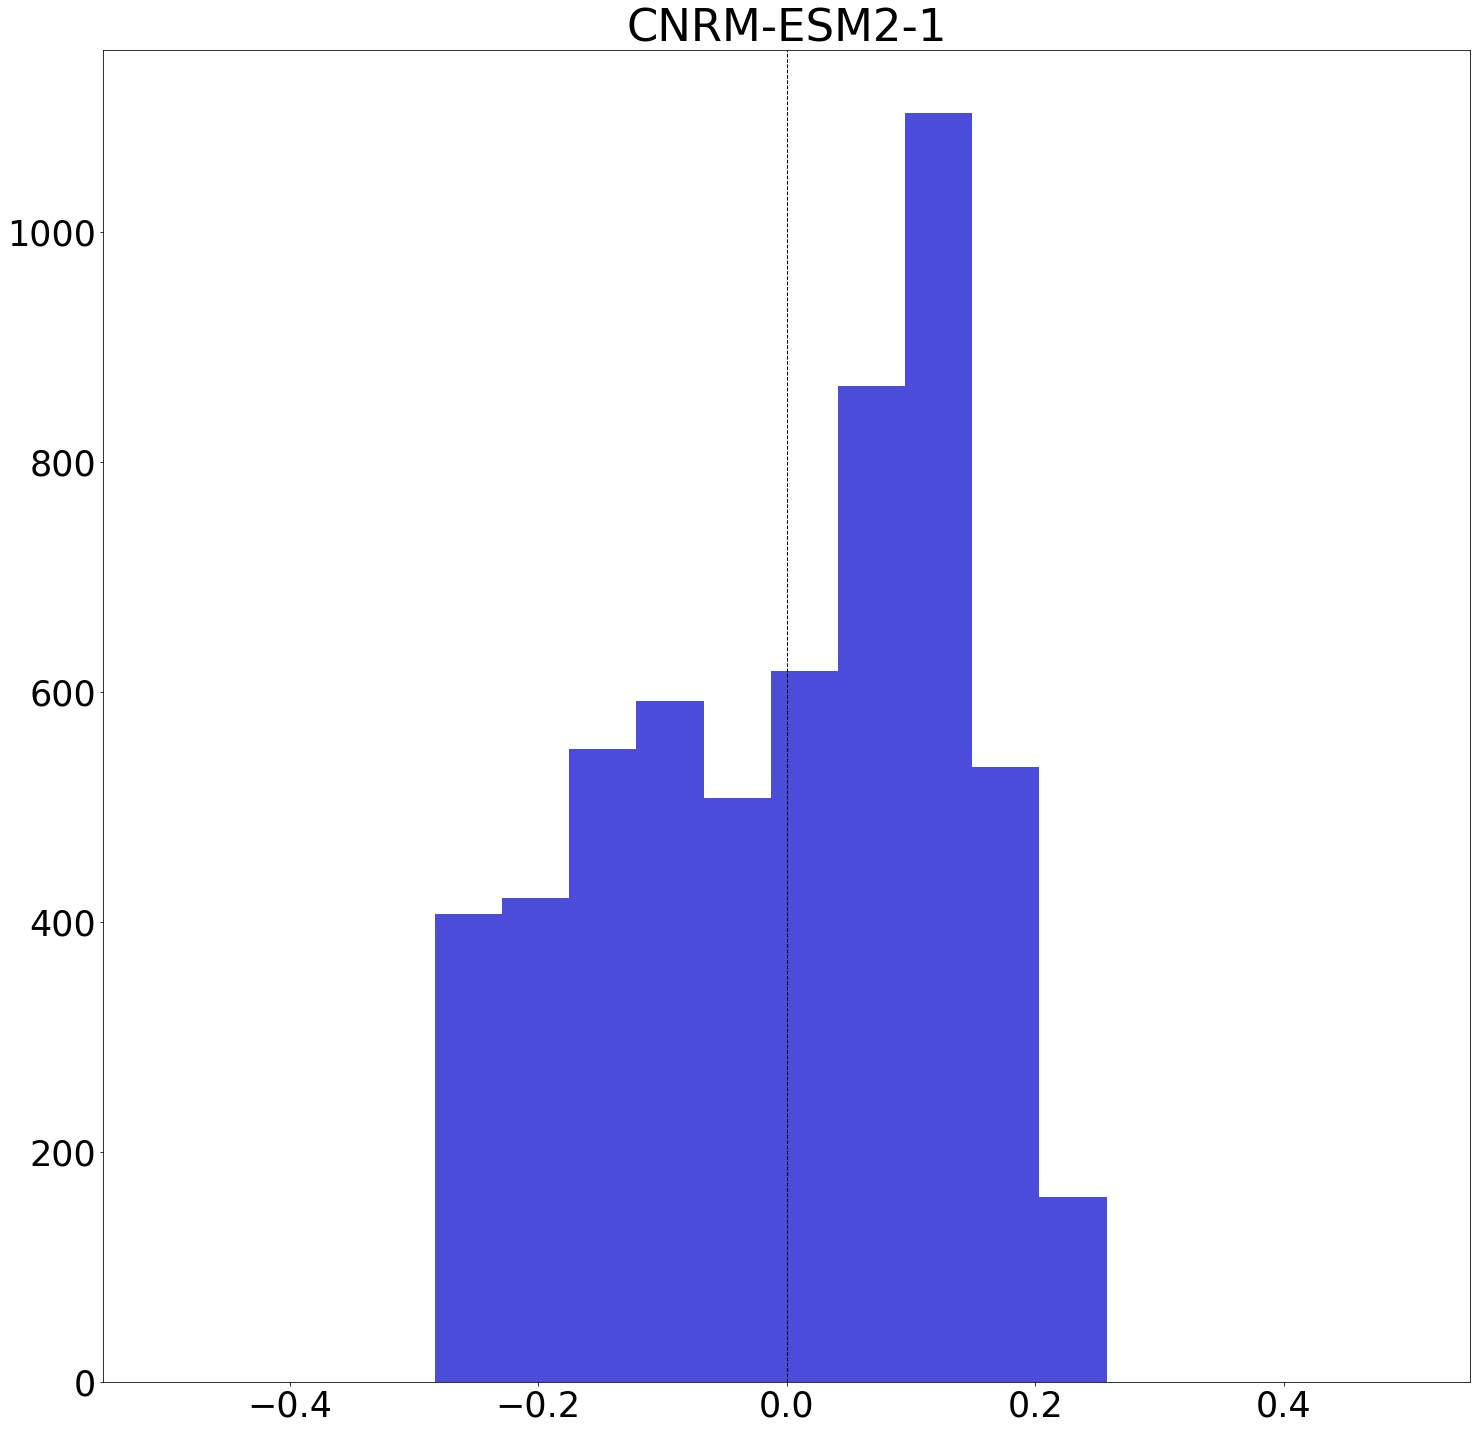

In [57]:
plot_histogram_for_single_model(binnum=10, xlims=[-0.55,0.55],m=8,avg_type=None)

### Run stats

In [32]:
import pickle
from plants_and_TCR.analyze_data import make_tcr_dataset

In [33]:
DIR_TCR_DICT = directory_information.DIR_TCR_DICT
TCR_DICT = pickle.load(open(DIR_TCR_DICT+'TCR_dict.pickle','rb'))

In [40]:
AVERAGE_TYPE = 'land'
END_YR=70
global_tcrs = make_tcr_dataset.make_tcr_dataset(TCR_DICT, end_yr = END_YR,
                                                average_type=AVERAGE_TYPE, varname='tas')
tcrs_phys = global_tcrs['TOT-RAD']

In [41]:
modelnames = get_CMIP_info.get_modelnames_short('CMIP5and6')
def calculate_p_val(baseline, signal):
    meanval = np.nanmean(baseline)
    stddev = np.std(baseline)
    z_score = (signal - meanval) / stddev
    pval = stats.norm.sf(z_score)
    return pval

for m in range(0, len(modelnames)):
    modelname = modelnames[m]  
    print('-------'+modelname+'-------')

    #------------ Get distribution of PI control --------------
    baseline_avgs = get_baseline_values(modelname=modelname, varname='tas',
                                        runname='piControl',cmip_dict=CMIP_DICT, area_avg=AVERAGE_TYPE)
    if baseline_avgs is not None:
        times = np.arange(0,len(baseline_avgs))
        [slope, intercept, _, _, _] = stats.linregress(times, baseline_avgs)
        linearfit = slope*(times)+intercept
        detrended_baseline_avgs = baseline_avgs - linearfit


        #----------- Get TCR--------------
        warming_phys = tcrs_phys[modelname]
        print(warming_phys)

        #---------- Check statistics-------
        z_thresh = stats.norm.ppf(0.95, loc =0, scale = 1)

        # For original baseline data
        pval = calculate_p_val(baseline_avgs, warming_phys)
        if pval <= 0.05:
            print('YES: '+ str(pval))
        else:
            print('NO: '+ str(pval))

        # For detrended baseline data
        pval = (calculate_p_val(detrended_baseline_avgs, warming_phys))
        if pval <= 0.05:
            print('YES: '+ str(pval))
        else:
            print('NO: '+ str(pval))
    else:
        print('No Baseline Data')

-------bcc-csm1-1-------
0.14461997151374817
YES: 0.0012237895687428597
YES: 0.001113416382968841
-------CanESM2-------
0.30201613903045654
YES: 2.5568407081598955e-09
YES: 1.6788890549620064e-11
-------CESM1-BGC-------
0.21513748168945312
YES: 1.093905505013281e-06
YES: 8.484580968067522e-07
-------GFDL-ESM2M-------
-0.10055442899465561
NO: 0.94417655541019
NO: 0.9413740239355706
-------HadGEM2-ES-------
0.8530437350273132
YES: 8.944243879520714e-15
YES: 2.102952637385542e-14
-------IPSL-CM5A-LR-------
0.15601418912410736
YES: 0.005120776678855246
YES: 0.005170955493404755
-------NorESM1-ME-------
0.28724780678749084
YES: 7.824663046638609e-69
YES: 4.5058729719929846e-70
-------MPI-ESM-LR-------
0.2518053948879242
YES: 2.562218372382744e-05
YES: 2.0390996078032098e-05
-------CNRM-ESM2-1-------
0.034433573484420776
NO: 0.42337829445258046
NO: 0.42811332759020315
-------BCC-CSM2-MR-------
0.11390219003343491
NO: 0.22526839079264382
NO: 0.17237462473456838
-------CanESM5-------
0.1996480